In [2]:
"""
This file provides the interface for building a MLP to train time series data to learn
new features from time series data, and the new features are well-aligned in feature space

Created by Zexi Chen(zchen22)
Date: Jan 26, 2017
"""

import numpy as np
import six.moves.cPickle as pickle
import tensorflow as tf
import matplotlib.pyplot as plt
import math

from MLP import FullyConnectedNet
from helper import loadData, dtw, euclideanDist
%matplotlib inline

ImportError: Traceback (most recent call last):
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/__init__.py", line 49, in <module>
    from tensorflow.python import pywrap_tensorflow
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/pywrap_tensorflow.py", line 28, in <module>
    _pywrap_tensorflow = swig_import_helper()
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/pywrap_tensorflow.py", line 24, in swig_import_helper
    _mod = imp.load_module('_pywrap_tensorflow', fp, pathname, description)
ImportError: libcudart.so.8.0: cannot open shared object file: No such file or directory


Error importing tensorflow.  Unless you are using bazel,
you should not try to import tensorflow from its source directory;
please exit the tensorflow source tree, and relaunch your python interpreter
from there.

In [22]:
# each sample* file contains 10000 time series, with each time series contains 23 data points
train_set = loadData('../theano/data/samples1')
valid_set = loadData('../theano/data/samples2')
test_set = loadData('../theano/data/samples3')

In [23]:
def makePairs(dataset, numInstance):
    # pick numInstance pairs of time series at random from the training set    
    sampleIndices = np.random.choice(dataset.shape[0], 2 * numInstance)
    data_set_samples = np.zeros((2 * numInstance, dataset.shape[1]),dtype=np.float32)
    for i in range(numInstance * 2):
        data_set_samples[i] = dataset[sampleIndices[i]]
    
    data_set_reshape = np.reshape(data_set_samples, (data_set_samples.shape[0]/2, data_set_samples.shape[1]*2))
    data_set1 = data_set_reshape/255.0
    data_dtws = np.zeros((data_set_reshape.shape[0],1), dtype=np.float32)
    for i in range(data_set_reshape.shape[0]):
        data_dtws[i,0] = dtw(data_set1[i,0:23], data_set1[i,23:])**2
    
    return data_set1, data_dtws

In [24]:
# shuffle, make pairs of time series,and calculate pair-wise dtw 
valid_set1, valid_dtws = makePairs(valid_set, valid_set.shape[0])
test_set1, test_dtws = makePairs(test_set, test_set.shape[0])

In [25]:
# start the tensorflow interaction interface
sess = tf.InteractiveSession()

Exception AssertionError: AssertionError("Nesting violated for default stack of <type 'weakref'> objects",) in <bound method InteractiveSession.__del__ of <tensorflow.python.client.session.InteractiveSession object at 0x7feba068bd10>> ignored


In [26]:
input_dim = 23


In [27]:
dropout = 0
regs = [0.1]
reg=0.1
hidden_dims = [200,100,50]
weight_scale = 0.1
learning_rates = [0.001]
training_epoch = 1000
numInstance = 1000
num_layers = len(hidden_dims)
params = {}
for i in xrange(num_layers):
    params["W"+str(i+1)] = None
    params["b"+str(i+1)] = None
best_valid_error = np.inf
    
for lr in learning_rates:
    for reg in regs:
        #print lr, reg
        # create two variable placehold, x for the training features, 
        # y for the labels(in this model it is the dtw distance between two time series)
        x = tf.placeholder(tf.float32, shape=[None, input_dim*2])
        y = tf.placeholder(tf.float32, shape=[None, 1])
        nnn = FullyConnectedNet(x, y, hidden_dims, input_dim, dropout = dropout, reg = reg,
                              weight_scale = weight_scale)
        loss = nnn.loss()
        train_step = tf.train.AdamOptimizer(lr).minimize(loss)
        sess.run(tf.initialize_all_variables())
        train_error = []
        valid_error = []
        for i in range(training_epoch):
            train_iter_error = []
            sample_train_set, sample_train_dtws = makePairs(train_set, numInstance)
            _, train_err = sess.run([train_step, loss], feed_dict = {x:sample_train_set, y:sample_train_dtws})
            train_iter_error.append(train_err)
            if i%100==0:
                train_error.append(np.mean(train_iter_error))
                train_iter_error = []
                ## need to change loss to prediction error
                valid_err = sess.run([loss], feed_dict={x:valid_set1, y:valid_dtws})
                valid_error.append(valid_err)
                print("step %d, mean training error %g, validation error %g"%(i, train_error[-1], valid_error[-1][0]))
                if valid_error[-1][0] < best_valid_error * 0.995:
                    for j in xrange(num_layers):
                        params["W"+str(j+1)] = sess.run(nn.layers[j].W)
                        params["b"+str(j+1)] = sess.run(nn.layers[j].b)
                    best_valid_error = valid_error[-1][0]
        # plot the training error and validation error
        Xaxis = [x * 100 for x in range(training_epoch/100)]
        plt.plot(Xaxis, train_error, 'r',label='train error')
        plt.plot(Xaxis, valid_error, 'g',label='validation error')
        plt.show()

TypeError: 'Variable' object is not iterable.

In [49]:
list1 = [1,2,3,4,5]

In [25]:
a1 = tf.truncated_normal([23,1,1,100], stddev=0.1)

In [39]:
a1.get_shape()

TensorShape([Dimension(23), Dimension(1), Dimension(1), Dimension(100)])

In [31]:
tf.reduce_sum(a1)

Tensor("Sum_14:0", shape=(), dtype=float32)


In [32]:
tf.reduce_sum(a1)

<tf.Tensor 'Sum_15:0' shape=() dtype=float32>

In [34]:
tf.nn.l2_loss(a1)

<tf.Tensor 'L2Loss:0' shape=() dtype=float32>

In [20]:
a1 = np.array([[1,2],[3,4]])

In [21]:
a1


array([[1, 2],
       [3, 4]])

In [22]:
a1**2

array([[ 1,  4],
       [ 9, 16]])

In [23]:
np.sum(a1**2)

30

ValueError: x and y must have same first dimension, but have shapes (10,) and (7,)

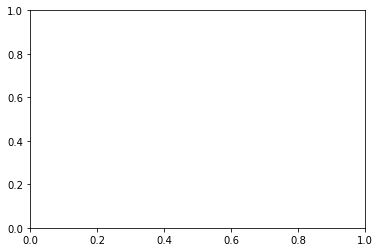

In [16]:
Xaxis = [x * 100 for x in range(training_epoch/100)]
plt.plot(Xaxis, np.log10(train_error), 'r',label='train error')
plt.plot(Xaxis, np.log10(valid_error), 'g',label='validation error')
plt.show()

In [11]:
#0.0001 0.1  16.672
# 0.001 0.1  9.57
# 0.01 0.01 14.0557
# 0.01 0.1 8.849

In [12]:
test_set2 = np.reshape(test_set1, (test_set1.shape[0]*2, test_set1.shape[1]/2))

In [13]:
input_test = test_set2           
for i in xrange(num_layers):
    if i == 0:
        W = np.reshape(params["W"+str(i+1)], [input_dim, hidden_dims[i]])
        output_test = sess.run(tf.nn.relu(np.matmul(input_test, W) + params["b"+str(i+1)]))
        input_test = output_test
    else:
        W = np.reshape(params["W"+str(i+1)], [hidden_dims[i-1], hidden_dims[i]])
        output_test = sess.run(tf.nn.relu(np.matmul(input_test, W) + params["b"+str(i+1)]))
        input_test = output_test

# reshape the W matrix to [23,10]
#W_1_prime = numpy.reshape(W_1,[23, n_hiddens[0]])
#hidden_1 = sess.run(tf.nn.relu(numpy.matmul(test_set2,W_1_prime)+b_1))
#W_2_prime = numpy.reshape(W_2,[n_hiddens[0], n_hiddens[1]])
#hidden_2 = sess.run(tf.nn.relu(numpy.matmul(hidden_1,W_2_prime)+b_2))
#W_3_prime = numpy.reshape(W_3,[n_hiddens[1], n_hiddens[2]])
#hidden_3 = tf.nn.relu(numpy.matmul(hidden_2,W_3_prime)+b_3)

In [14]:
input_test.shape

(20000, 50)

In [15]:
# evaluate function
def evaluateFunc(num, ori_set, new_set, nn, nNeighbor=100):
    '''
        num: the number of sample time series we use to evaluate the performance of our neural network model
        ori_set: it is the original dataset
        new_set: this is the dataset generated after we perform our neural network model on our original dataset
        nn: the number of time series we use to calculate the dtw and euclidean distance
        nNeighbor: the number of neighbors we extracted to compare the overlap between dtw and euclidean distances
    '''
    result = []
    for n in range(num):
        euclidean_dists = []
        dtw_dists = []
        for i in range(nn):
            dtw_dists.append((i,dtw(ori_set[i], ori_set[nn + n])))
            euclidean_dists.append((i, euclideanDist(new_set[i], new_set[nn + n])))
        euclidean_dists_sorted = sorted(euclidean_dists, key=(lambda x: x[1]))
        dtw_dists_sorted = sorted(dtw_dists, key=(lambda x: x[1]))
        euclid_set = set()
        dtw_set = set()
        for i in range(nNeighbor):
            euclid_set.add(euclidean_dists_sorted[i][0])
            dtw_set.add(dtw_dists_sorted[i][0])
        count = 0
        for x in euclid_set:
            if x in dtw_set:
                count += 1
        result.append(float(count)/nNeighbor)
    return reduce(lambda x, y: x + y, result)/len(result)

In [16]:
perform = evaluateFunc(1000, test_set2, input_test, 1000)

In [17]:
print perform

0.75504


In [21]:
perform1 = evaluateFunc(1000, test_set2, input_test, 1000, nNeighbor = 5)

In [22]:
print perform1

0.4192
